In [1]:
import catboost
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import pandas as pd
import scikitplot as skplt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report

In [2]:
# monkey patching iid bug
def bayes_search_CV_init(self, estimator, search_spaces, optimizer_kwargs=None,
                         n_iter=50, scoring=None, fit_params=None, n_jobs=1,
                         n_points=1, iid=True, refit=True, cv=None, verbose=0,
                         pre_dispatch='2*n_jobs', random_state=None,
                         error_score='raise', return_train_score=False):

        self.search_spaces = search_spaces
        self.n_iter = n_iter
        self.n_points = n_points
        self.random_state = random_state
        self.optimizer_kwargs = optimizer_kwargs
        self._check_search_space(self.search_spaces)
        self.fit_params = fit_params

        super(BayesSearchCV, self).__init__(
             estimator=estimator, scoring=scoring,
             n_jobs=n_jobs, refit=refit, cv=cv, verbose=verbose,
             pre_dispatch=pre_dispatch, error_score=error_score,
             return_train_score=return_train_score)
        
BayesSearchCV.__init__ = bayes_search_CV_init

In [3]:
df = pd.read_parquet("combined.parquet")
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

df["FEAT1"] = df["Number_of_Casualties"]/df["Number_of_Vehicles"]
df["FEAT2"] = (df["Age_of_Driver_mean"] - df["Age_of_Driver_min"])/(df["Age_of_Driver_max"] - df["Age_of_Driver_min"] + 1)
df["FEAT3"] = (df["Age_of_Vehicle_mean"] - df["Age_of_Vehicle_min"])/(df["Age_of_Vehicle_max"] - df["Age_of_Vehicle_min"] + 1)
df["FEAT4"] = (df["Age_of_Casualty_mean_mean"] - df["Age_of_Casualty_min_min"])/(df["Age_of_Casualty_max_max"] - df["Age_of_Casualty_min_min"] + 1)
df["FEAT5"] = df["Male_Casaulties_sum_sum"]/df["Number_of_Casualties"]

print(df.shape)

(1640353, 94)


In [4]:
df.drop(columns=[col for col in df if "IMD" in col], inplace=True)

In [5]:
df.drop(columns=["CasaultyFatal_sum_sum", "CasaultySerious_sum_sum", "CasaultySlight_sum_sum",
                 "Accident_Index", "Date", "Local_Authority_(District)", "1st_Road_Number",
                 "2nd_Road_Number"], inplace=True, errors="ignore")

In [6]:
categorical_columns = [
    '1st_Road_Class', 'Road_Type', 'Speed_limit', 'Junction_Detail',
    'Junction_Control', '2nd_Road_Class',
    'Pedestrian_Crossing-Human_Control',
    'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
    'Weather_Conditions', 'Road_Surface_Conditions',
    'Special_Conditions_at_Site', 'Carriageway_Hazards',
    'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident'
]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["Accident_Severity"]), df["Accident_Severity"], test_size=0.25, shuffle=False
)

In [8]:
# X_train, X_valid, y_train, y_valid = train_test_split(
#     X_train, y_train, test_size=0.2, shuffle=False
# )

In [9]:
clf = catboost.CatBoostClassifier(od_type="Iter", loss_function='MultiClass', iterations=100)

param_distrib = {
    'max_depth': list(range(5, 10)),
    'learning_rate': [0.5, 0.6, 0.7, 0.8, 0.9],
    'l2_leaf_reg': list(range(2, 11)),
}

ts_cv = TimeSeriesSplit(n_splits=3)

searcher = RandomizedSearchCV(
    clf,
    param_distrib,
    scoring="balanced_accuracy",
    cv=ts_cv,
    n_jobs=-1,
    n_iter=20,
    random_state=0
)

searcher.fit(X_train, y_train)

0:	learn: 0.4953521	total: 1.69s	remaining: 2m 47s
1:	learn: 0.4330454	total: 3.34s	remaining: 2m 43s
2:	learn: 0.4104917	total: 4.98s	remaining: 2m 40s
3:	learn: 0.4001819	total: 6.61s	remaining: 2m 38s
4:	learn: 0.3958304	total: 8.25s	remaining: 2m 36s
5:	learn: 0.3936244	total: 9.86s	remaining: 2m 34s
6:	learn: 0.3916324	total: 11.5s	remaining: 2m 32s
7:	learn: 0.3901587	total: 13.1s	remaining: 2m 30s
8:	learn: 0.3891544	total: 14.7s	remaining: 2m 29s
9:	learn: 0.3885388	total: 16.4s	remaining: 2m 27s
10:	learn: 0.3880220	total: 18s	remaining: 2m 25s
11:	learn: 0.3872546	total: 19.6s	remaining: 2m 23s
12:	learn: 0.3867046	total: 21.3s	remaining: 2m 22s
13:	learn: 0.3863189	total: 22.9s	remaining: 2m 20s
14:	learn: 0.3853110	total: 24.5s	remaining: 2m 18s
15:	learn: 0.3850285	total: 26.1s	remaining: 2m 17s
16:	learn: 0.3846692	total: 27.7s	remaining: 2m 15s
17:	learn: 0.3843283	total: 29.4s	remaining: 2m 13s
18:	learn: 0.3839567	total: 31s	remaining: 2m 12s
19:	learn: 0.3833715	total

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fc43d312210>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'l2_leaf_reg': [2, 3, 4, 5, 6, 7, 8, 9,
                                                        10],
                                        'learning_rate': [0.5, 0.6, 0.7, 0.8,
                                                          0.9],
                                        'max_depth': [5, 6, 7, 8, 9]},
                   random_state=0, scoring='balanced_accuracy')

In [10]:
# didn't work due to bug
# clf = catboost.CatBoostClassifier(od_type="Iter", loss_function='MultiClass')

# param_distrib = {
#     'iterations': Integer(10, 200),
#     'depth': Integer(2, 8),
#     'learning_rate': Real(0.01, 1.0, 'log-uniform'),
#     'random_strength': Real(1e-9, 10, 'log-uniform'),
#     'l2_leaf_reg': Integer(2, 30),
# }

# ts_cv = TimeSeriesSplit(n_splits=3)

# opt = BayesSearchCV(
#     clf,
#     param_distrib,
#     scoring="accuracy",
#     cv=ts_cv,
#     n_jobs=-1,
#     return_train_score=False,
#     refit=True,
#     random_state=0
# )

# opt.fit(X_train, y_train)

In [11]:
model = searcher.best_estimator_

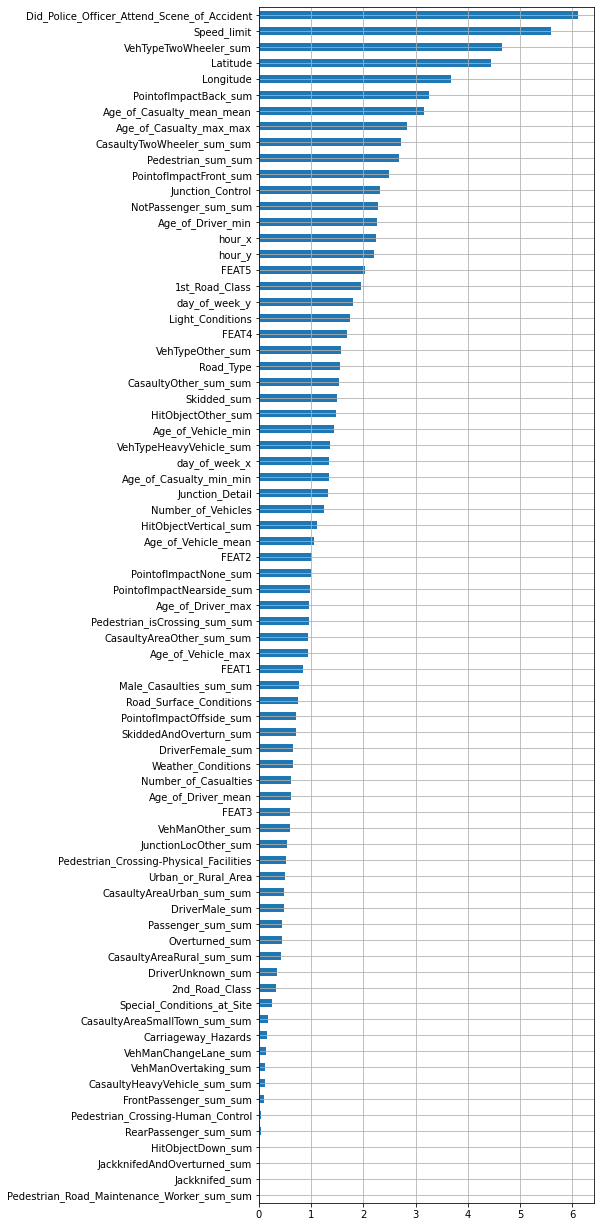

In [12]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=True).plot(kind='barh', figsize=(6, 22))
plt.grid()

In [13]:
y_pred = model.predict(X_test)

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.31      0.08      0.12      4683
           2       0.49      0.09      0.15     58356
           3       0.86      0.99      0.92    347050

    accuracy                           0.85    410089
   macro avg       0.55      0.38      0.40    410089
weighted avg       0.80      0.85      0.80    410089



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

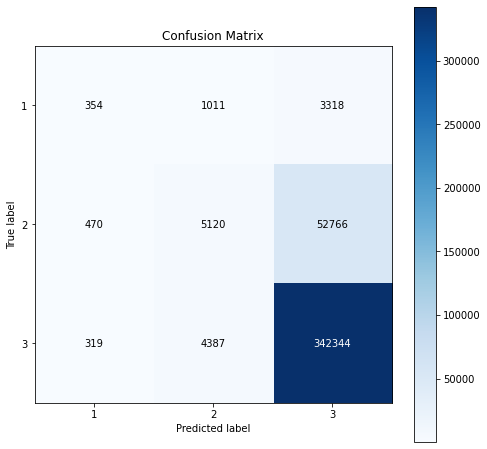

In [15]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(8, 8))

## Check for overfitting

In [16]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           1       0.62      0.14      0.22     16698
           2       0.58      0.11      0.19    163644
           3       0.87      0.99      0.93   1049922

    accuracy                           0.86   1230264
   macro avg       0.69      0.41      0.45   1230264
weighted avg       0.83      0.86      0.82   1230264



In [17]:
from sklearn.metrics import accuracy_score

In [18]:
accuracy_score(y_test, y_pred)

0.848152474219011

In [19]:
searcher.best_params_

{'max_depth': 9, 'learning_rate': 0.8, 'l2_leaf_reg': 3}

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640353 entries, 0 to 1640352
Data columns (total 76 columns):
 #   Column                                       Non-Null Count    Dtype  
---  ------                                       --------------    -----  
 0   Longitude                                    1640353 non-null  float64
 1   Latitude                                     1640353 non-null  float64
 2   Number_of_Vehicles                           1640353 non-null  int64  
 3   Number_of_Casualties                         1640353 non-null  int64  
 4   1st_Road_Class                               1640353 non-null  int64  
 5   Road_Type                                    1640353 non-null  int64  
 6   Speed_limit                                  1640353 non-null  int64  
 7   Junction_Detail                              1640353 non-null  int64  
 8   Junction_Control                             1640353 non-null  int64  
 9   2nd_Road_Class                               1